In [28]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt # standard graphics
import seaborn as sns # fancier graphics
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

In [29]:
#reading file
df = pd.read_csv("diabetes.csv")

In [30]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [31]:
def outlier(df,col):
    fqr = df[col].quantile(0.25)
    tqr = df[col].quantile(0.75)
    iqr = tqr-fqr
    df_out = df[(df[col]>1.5*iqr +tqr)| (df[col]<fqr -1.5*iqr)]
    #silmek ucun code
    # idx = df_out[col].index().tolist()
    # df.drop(idx, axis = 0, inplace = True)
    return df_out

In [32]:
def scale_check(df):
    l = df.describe()
    b = l[l.index=='mean'].values
    return b.max()-b.min()>10

In [33]:
def check_df(df):
    out = []

    for col in df.columns:
        if df.apply(lambda x: x.isnull().sum()).sum():
            print(f"you got the problem at column {col}")
        #sparsity check
        assert pd.api.types.is_sparse(df[col]) == False
        df_out = outlier(df, col)
        #outlier detection
        if len(df_out)>0:
            print(f"you got outlier at column {col}")
            out.append(col)
    #scalability check
    if scale_check(df) == True:
        print("There is scalability issue")
    #balance check
    a = df["Outcome"].value_counts()
    if a.max()-a.min()>30:
        print("You got balance problem")
    return out

In [34]:
out = check_df(df)

you got outlier at column Pregnancies
you got outlier at column Glucose
you got outlier at column BloodPressure
you got outlier at column SkinThickness
you got outlier at column Insulin
you got outlier at column BMI
you got outlier at column DiabetesPedigreeFunction
you got outlier at column Age
There is scalability issue
You got balance problem


In [35]:
df.boxplot(out, rot = 45)

<AxesSubplot: title={'center': 'Error Rate K Value'}, xlabel='K Value', ylabel='Mean Error'>

In [36]:
out_age = outlier(df, "DiabetesPedigreeFunction")
out_age["DiabetesPedigreeFunction"]

4      2.288
12     1.441
39     1.390
45     1.893
58     1.781
100    1.222
147    1.400
187    1.321
218    1.224
228    2.329
243    1.318
245    1.213
259    1.353
292    1.224
308    1.391
330    1.476
370    2.137
371    1.731
383    1.268
395    1.600
445    2.420
534    1.251
593    1.699
606    1.258
618    1.282
621    1.698
622    1.461
659    1.292
661    1.394
Name: DiabetesPedigreeFunction, dtype: float64

In [37]:
df_out = outlier(df, "BMI")

In [38]:
sns.boxplot(df['BMI'])

<AxesSubplot: title={'center': 'Error Rate K Value'}, xlabel='K Value', ylabel='Mean Error'>

In [39]:
df['BMI'].std()

7.8841603203754405

In [40]:
l = df[df["BMI"]>50].index.tolist() + df[df["BMI"]<5].index.tolist()
df_out = outlier(df, "BMI")

In [41]:
l

[120,
 125,
 177,
 193,
 247,
 303,
 445,
 673,
 9,
 49,
 60,
 81,
 145,
 371,
 426,
 494,
 522,
 684,
 706]

In [42]:
df_out.index

Index([  9,  49,  60,  81, 120, 125, 145, 177, 193, 247, 303, 371, 426, 445,
       494, 522, 673, 684, 706],
      dtype='int64')

In [43]:
#Observing the first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


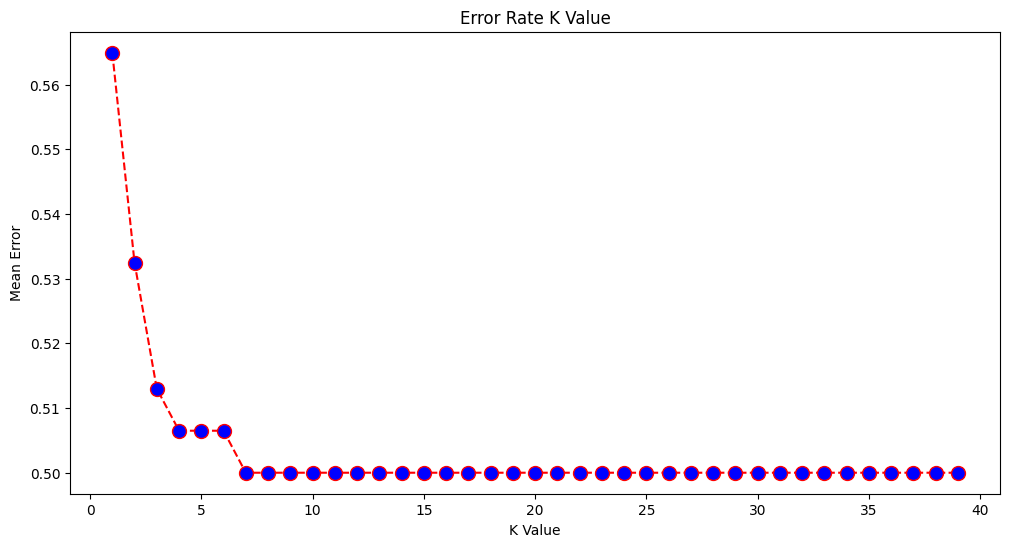

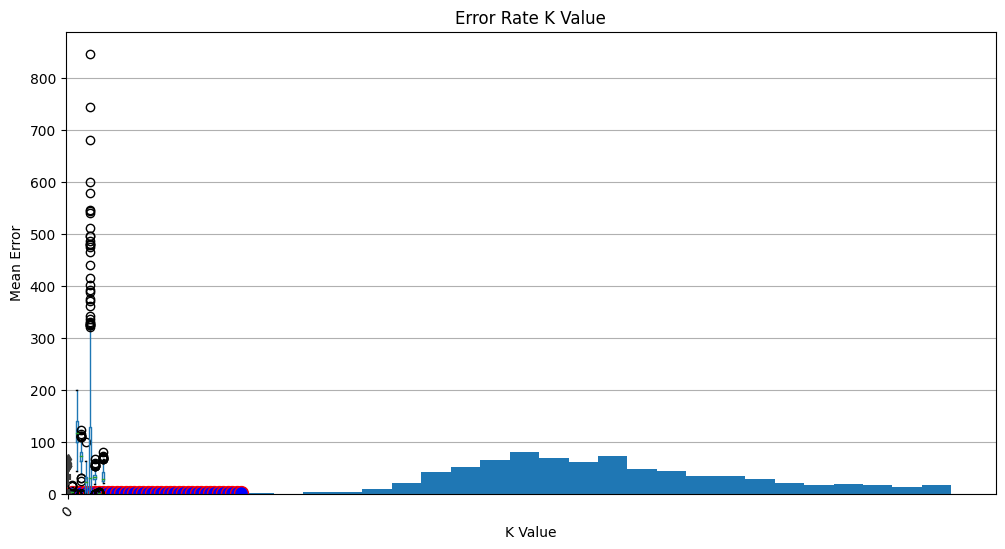

In [44]:
#Checking scalability 
plt.hist(df['Glucose'], bins=30)
plt.show()

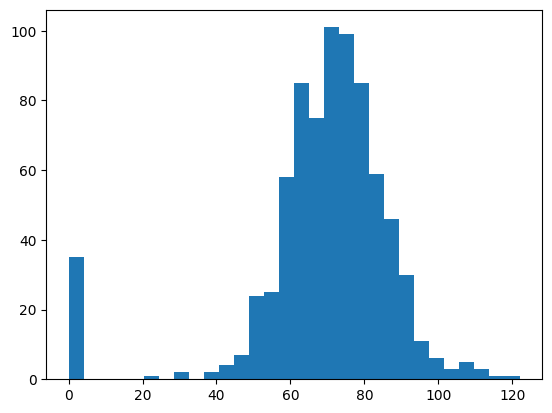

In [45]:
plt.hist(df['BloodPressure'], bins=30)
plt.show()

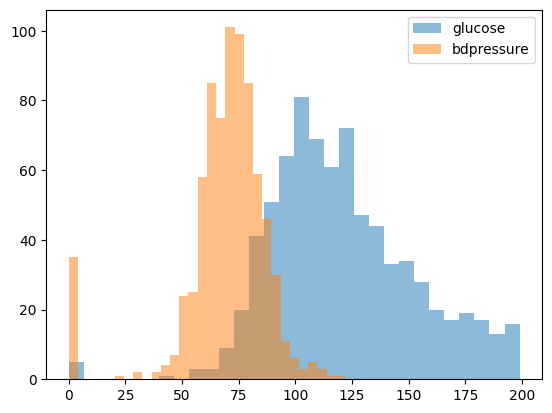

In [46]:
glucose = [df['Glucose']]
bdpressure = [df['BloodPressure']]
plt.hist(glucose, alpha=0.5, label='glucose', bins=30)
plt.hist(bdpressure, alpha=0.5, label='bdpressure', bins=30)
plt.legend(loc='upper right')
plt.show()

*Apparently there is a scalability issue which is quite important for KNN algorithms mainly due to the reason that it computes the distance to the  K values in the neighborhood. 

In [47]:
def scaling_apply(X_train, X_test):
    #Scaling
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [48]:
def preprocess(df):
    #Preprocessing
    #X = df.drop("Outcome",axis =1) alternative
    #y = df["Outcome"]
    X = df.iloc[:, :-1].values
    y = df.iloc[:, 4].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    if scale_check(df)==True:
        X_train, X_test = scaling_apply(X_train, X_test)
    return X_train, X_test, y_train, y_test

In [49]:
X_train, X_test, y_train, y_test = preprocess(df)

*Beforing running KNN algorithm there is a need to bring all variables to the same scale as computation is based on Euclidean Distance. From this point of view, KNN is pretty sensitive to the scale. 

In [50]:
#Running KNN algorithm
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [51]:
#Predicting on test dataset in order to compare with the train dataset 
y_pred = classifier.predict(X_test)

In [52]:
#Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[79  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        80
          15       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          50       0.00      0.00      0.00         2
          51       0.00      0.00      0.00         0
          53       0.00      0.00      0.00         1
          54       0.00      0.00

In [53]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [55]:
#Plotting mean error against K value
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Text(0, 0.5, 'Mean Error')

In [ ]:
#Calculating mean accuracy, standarnd deviation accuracy 
#Checking accuracy results for different number of K values
Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

In [ ]:
#Plotting accuracy against number of K neighbors 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [ ]:
#Checking the k value for which the model gets the highest accuracy 
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

*After solving scalability issue KNN algorithm was executed on train and test set. After making confusion matrix model yielded lower accuracy result. Therefore, mean error was calculated. According to the plot which shows mean error against number of neighbors one can visually observe that the number of neighbors between 15 and 20 results in the lower mean error. Subsequently, I tried to check accuracy results for different number of neighbors and plotted accuracy against numbers of neighbors. In the end, I checked the K value for which the model gets the highest accuracy. K value at 18 gets the best accuracy. In general, accuracy results are below 53%. If we compare n_neighbors=5 and n_neighbors=18 we will see that accuracy improves only 2%. Therefore, one can claim these results are not related to KNN algorithm. In order to improve accuracy classification models can be applied as this dataset is related to diabetics and it has 2 binary outcomes.